In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from uitils import *
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, recall_score, f1_score, confusion_matrix

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import lightgbm as lgb
print('GPU support:', lgb.LGBMClassifier(device='gpu').get_params()['device'])



Num GPUs Available:  1
GPU support: gpu


# Data Loading

In [4]:
import numpy as np
from keras.datasets import mnist
import lightgbm as lgb
from sklearn.metrics import accuracy_score

# Random samples selector
def extract_samples(x, y, num_samples):
    indices = np.random.choice(x.shape[0], num_samples, replace=False)
    return x[indices], y[indices]

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, y_train = extract_samples(x_train, y_train, 500)
# x_test, y_test = extract_samples(x_test, y_test, 100)
print("Reduced training set shape:", x_train.shape)
print("Reduced testing set shape:", x_test.shape)

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten the images for LightGBM
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# Convert labels to 0 (even) and 1 (odd)
y_train = y_train % 2
y_test = y_test % 2

# Initialize 's' to zeros, meaning initially all are unlabeled
s = np.zeros_like(y_train)

# Select a random 1000 samples where y_train == 1 to be labeled
positive_indices = np.where(y_train == 1)[0]
chosen_indices = np.random.choice(positive_indices, size=1000)

# Mark these as labeled in 's'
s[chosen_indices] = 1

# Mark the rest of the positive_indices except the chosen 1000 as potential targets for unlabeled marking
rest_of_positives = np.setdiff1d(positive_indices, chosen_indices)

# From the rest, select 3% and mark their labels as 0 in y_train
number_to_mark_unlabeled = int(len(rest_of_positives) * 0.03)
unlabeled_indices = np.random.choice(rest_of_positives, size=number_to_mark_unlabeled)
y_train[unlabeled_indices] = 0

# Remove the rest of the positive rows that are not in the chosen 1000 and not marked as unlabeled
indices_to_drop = np.setdiff1d(rest_of_positives, np.concatenate([chosen_indices, unlabeled_indices]))
x_train = np.delete(x_train, indices_to_drop, axis=0)
y_train = np.delete(y_train, indices_to_drop)
s = np.delete(s, indices_to_drop)

print("Training labels distribution:", np.bincount(y_train))
print("Training original labels distribution:", np.bincount(s))


Reduced training set shape: (60000, 28, 28)
Reduced testing set shape: (10000, 28, 28)
Training labels distribution: [30366   982]
Training original labels distribution: [30366   982]


# Pre-training

In [5]:
# Import LightGBM
import lightgbm as lgb

#  datasets creation for LightGBM
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test)

##parameters for LightGBM
params = {
    'boosting_type': 'gbdt',        # Gradient boosting decision tree
    'objective': 'binary',          # Binary classification
    'metric': 'binary_logloss',     # Evaluation metric
    'num_leaves': 31,               # Number of leaves in full tree
    'learning_rate': 0.01,          # Learning rate
    'feature_fraction': 0.9,        # Fraction of features to be used at each iteration
    'bagging_fraction': 0.8,        # Fraction of data to be used for each iteration
    'bagging_freq': 5,              # Frequency for bagging
    'device': 'gpu',                # Use GPU for training
    'verbose': 1                    # Verbose output
}

# boosting rounds
num_boost_round = 15

#  model
model_lgb = lgb.train(params, train_data, num_boost_round=num_boost_round, valid_sets=[test_data])

model_lgb.save_model('lgb_model_mnist.weights.h5')

# predicted probabilities
y_pred_prob = model_lgb.predict(x_test)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.056155 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031326 -> initscore=-3.431488
[LightGBM] [Info] Start training from score -3.431488
Accuracy: 0.4926


Classifer predicted labels distribution: [   28 31320]


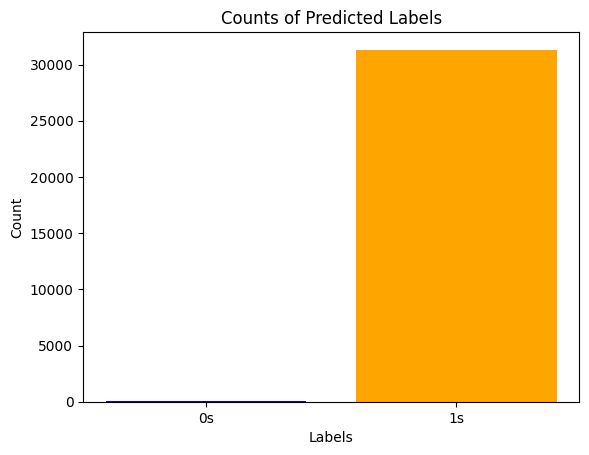

In [6]:
y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
threshold = min(y_pred[y_train == 1])
lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

bin_ploter(predicted_labels=lgb_predicted_labels)

### Probablistic outcome of classifer to pre-train policy network
 

In [7]:
# Policy-Network Model

class PolicyGradientNetwork:
    def __init__(self):
        self.model = self._create_model()
    
    def _create_model(self):
        model = Sequential([
            Dense(64, input_shape=(input_dimension,)),  # Adjust `input_dimension` to match your feature count
            Activation('relu'),
            Dense(128),
            Activation('relu'),
            Dense(64),
            Activation('relu'),
            Dense(32),
            Activation('relu'),
            Dense(16),
            Activation('relu'),
            Dense(1),  # Output layer for binary classification
            Activation('sigmoid')
        ])
        return model
    
    def get_model(self):
        return self.model
    
input_dimension = x_train.shape[1]
policy_network = PolicyGradientNetwork()
pn_model = policy_network.get_model()

pn_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# fit the model with one-hot encoded labels
# history_2 = pn_model.fit(x_train.to_numpy(), lgb_predicted_labels, epochs=60, batch_size=5, validation_split=0.2)
history_2 = pn_model.fit(x_train, lgb_predicted_labels, epochs=15, batch_size=128, validation_split=0.2)
pn_model.save_weights('pn_mlp_model_.weights.h5')
# pn_model.load_weights('pn_mlp_model_.weights.h5')

Epoch 1/15
196/196 [==============================] - 10s 40ms/step - loss: 0.0203 - accuracy: 0.9941 - val_loss: 0.0130 - val_accuracy: 0.9989
Epoch 2/15
196/196 [==============================] - 8s 41ms/step - loss: 0.0083 - accuracy: 0.9992 - val_loss: 0.0119 - val_accuracy: 0.9989
Epoch 3/15
196/196 [==============================] - 8s 43ms/step - loss: 0.0076 - accuracy: 0.9992 - val_loss: 0.0098 - val_accuracy: 0.9989
Epoch 4/15
196/196 [==============================] - 8s 41ms/step - loss: 0.0083 - accuracy: 0.9992 - val_loss: 0.0156 - val_accuracy: 0.9989
Epoch 5/15
196/196 [==============================] - 7s 36ms/step - loss: 0.0081 - accuracy: 0.9992 - val_loss: 0.0146 - val_accuracy: 0.9989
Epoch 6/15
196/196 [==============================] - 7s 36ms/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 0.0110 - val_accuracy: 0.9989
Epoch 7/15
196/196 [==============================] - 6s 33ms/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 0.0109 - val_accuracy: 0.998

980/980 [==============================] - 10s 10ms/step
Classifer predicted labels distribution: [   13 31335]


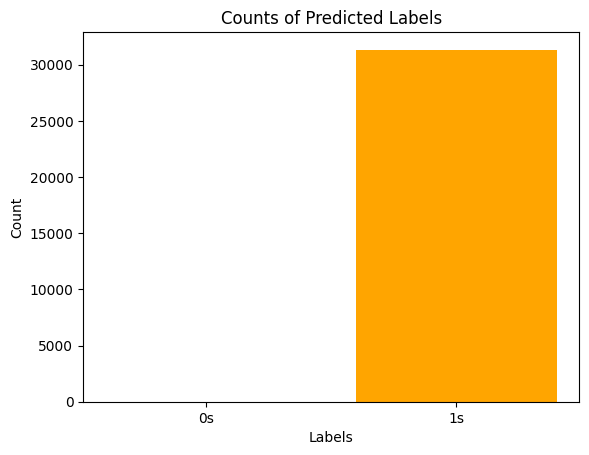

In [8]:
probabilities = pn_model.predict(x_train)
threshold = min(probabilities[y_train == 1])

# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
np_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(np_predicted_labels))
bin_ploter(predicted_labels=np_predicted_labels)

## Interactive learning

In [9]:
class Agent:
    def __init__(self, model, target_model, alpha=0.00001, gamma=0.99):
        self.gamma = gamma  # Discount factor
        self.lr = alpha  # Learning rate
        self.model = model  # Policy model
        self.target_model = target_model # target policy model
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    
    def choose_action(self, states, s, threshold=0.5):
        # Convert states to float32 tensor within the function
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        probabilities = self.target_model(states) 
        
        inferred_labels = tf.cast(probabilities > threshold, tf.int32)       
        s = tf.reshape(s, tf.shape(inferred_labels))  # ensuring s is the same shape as inferred_labels
        actions = tf.where(s == 1, 1, inferred_labels)
        actions = tf.squeeze(actions)  # should correctly squeeze actions to shape (128,)
        return actions.numpy(), probabilities.numpy()



    def store_transition(self, states, actions, rewards):
        self.state_memory.extend(states)
        self.action_memory.extend(actions)
        self.reward_memory.extend(rewards)

    def learn(self):
        actions = np.array(self.action_memory)
        rewards = np.array(self.reward_memory)
        states = np.array(self.state_memory)

        # discounted rewards
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma

            G[t] = G_sum

        # updating policy
        with tf.GradientTape() as tape:
            loss = 0

            for idx, (g, state) in enumerate(zip(G, states)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.model(state, training=True)
                action_probs = tf.where(actions[idx] == 1, probs, 1 - probs)
                log_prob = tf.math.log(action_probs)
                loss += -g * tf.reduce_sum(log_prob)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # clearing memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []


In [10]:
# cloning policy model for stable target policy
target_policy_model = tf.keras.models.clone_model(pn_model)
target_policy_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[],
    'recall':[],
    'f1':[]
}

agent = Agent(pn_model,target_model=target_policy_model, alpha=0.00001, gamma=0.99)
# Example parameters
n_epochs = 300
# n_epochs = 10 #for testing
batch_size = 128 # You can adjust the batch size as needed

def shuffle_data(x_train, y_train, s):
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    return x_train[indices], y_train[indices], s[indices]

def create_mini_batches(x_train, y_train, s, batch_size):
    for start_idx in range(0, len(x_train) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield x_train[excerpt], y_train[excerpt], s[excerpt]

def calculate_threshold(clf_probabilities, y_batch):
    # Identify indices of positive examples
    positive_indices = (y_batch == 1)
    
    # Calculate threshmin from positive examples
    if np.any(positive_indices):
        threshmin = np.min(clf_probabilities[positive_indices])
    else:
        threshmin = 0  # Default value if no positive examples are present

    # Identify U0 - samples with predictions >= threshmin
    U0_indices = (clf_probabilities >= threshmin)
    
    # Calculate the final threshold using Equation 5
    if np.any(U0_indices):
        threshold = np.mean(clf_probabilities[U0_indices])
    else:
        threshold = threshmin  # Use threshmin if no samples meet the U0 criteria

    return threshold

def calculate_rewards(clf_probabilities, y_batch, threshold):
    # Reward calculation needs to consider whether predictions meet a certain threshold
    # Positive examples above threshold or negative examples below threshold get positive rewards
    rewards = []
    for prob, actual in zip(clf_probabilities.flatten(), y_batch):
        if actual == 1 or (actual == 0 and prob >= threshold):
            reward = prob  # Reward is the probability itself if conditions are met
        else:
            reward = prob -1  # Otherwise, reward is the complement of the probability
        rewards.append(reward)
    return rewards

In [12]:
# num_initial_round = 5
# model_lgb = lgb.train(params, train_data, num_boost_round=num_initial_round, valid_sets=[test_data])
# model_lgb.save_model('lgb_model.we7ights.h5')


# y_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
# threshold = min(y_pred[y_train == 1])
# lgb_predicted_labels = np.array([1 if pred >= threshold else 0 for pred in y_pred])
# print("Classifer predicted labels distribution:", np.bincount(lgb_predicted_labels))

In [13]:
def train_model(x_train, y_train, s, epochs=300, batch_size=128, model_lgb=model_lgb):
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    s = s.astype('float32')

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, s))
    dataset = dataset.shuffle(buffer_size=len(x_train)).batch(len(y_train))
    # dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        # lgb_probabilities=None
        threshold = 0.5
        for x_batch, y_batch, s_batch in dataset:
            # Get actions and probabilities for the entire batch
            actions, probabilities = agent.choose_action(x_batch, s_batch, threshold=threshold)
            train_data = lgb.Dataset(x_batch, label=actions)
            valid_data = lgb.Dataset(x_batch, label=actions)
            model_lgb = lgb.train(params, train_data, num_boost_round=10, init_model=model_lgb, keep_training_booster=True)
    

            # Fit the model on the current batch and update history

            lgb_probabilities = model_lgb.predict(x_batch, num_iteration=model_lgb.best_iteration)
            threshold = calculate_threshold(lgb_probabilities, y_batch)
            rewards = calculate_rewards(lgb_probabilities, y_batch, threshold)

            # Store transitions and learn from them
            agent.store_transition(x_batch.numpy(), actions, rewards)
            agent.learn()
            # break

        y_pred_prob = model_lgb.predict(x_test)
        threshold = calculate_threshold(y_pred_prob, y_test)
        print(f"threshold: {threshold}")
        y_pred = np.where(y_pred_prob >= threshold, 1, 0)

        roc_auc = roc_auc_score(y_test, y_pred_prob)
        print("AUC-ROC:", roc_auc)
        history['ROC_AUC'].append(roc_auc)

        accuracy = accuracy_score(y_test, y_pred)
        print("Accuracy:", accuracy)
        history['accuracy'].append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_pred_prob)
        pr_auc = auc(recall, precision)
        history['PR_AUC'].append(pr_auc)
        print("PR_AUC:", pr_auc)

        # conf_matrix = confusion_matrix(y_test, y_pred)
        # print("Confusion Matrix:")
        # print(conf_matrix)
        # Test the confustion matrix and test the inputs

        # recall = recall_score(y_test, y_pred)
        # print("Recall:", recall)
        # history['recall'].append(recall)

        # # Calculate F1 score
        # f1 = f1_score(y_test, y_pred)
        # print("F1 Score:", f1)
        # history['f1'].append(f1)


        if epoch % 3 == 0:
            print("Updating target policy...")
            agent.target_model.set_weights(agent.model.get_weights())


train_model(x_train=x_train, y_train=y_train, s=y_train, model_lgb=model_lgb)

Epoch 1/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 28669, number of negative: 2679
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.040914 secs. 1 sparse feature groups
threshold: 0.14581506530547028
AUC-ROC: 0.8658050459372622
Accuracy: 0.8266
PR_AUC: 0.9141675744816804
Updating target policy...
Epoch 2/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.052537 secs. 1 sparse feature groups
threshold: 0.1462981844676173
AUC-ROC: 0.9020932144977035
Accuracy: 0.8427
PR_AUC: 0.9376099197849818
Epoch 3/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.044096 secs. 1 sparse feature groups
threshold: 0.14737924054743318
AUC-ROC: 0.9219503239989688
Accuracy: 0.8513
PR_AUC: 0.9503761738457178
Epoch 4/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.051793 secs. 1 sparse feature groups
threshold: 0.14816304894821775
AUC-ROC: 0.9354067314904656
Accuracy: 0.8523
PR_AUC: 0.9582096857783631
Updating target policy...
Epoch 5/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.044643 secs. 1 sparse feature groups
threshold: 0.14861333788440423
AUC-ROC: 0.9422866784740529
Accuracy: 0.8543
PR_AUC: 0.9622414831760171
Epoch 6/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.043825 secs. 1 sparse feature groups
threshold: 0.14978237462532337
AUC-ROC: 0.953880618010569
Accuracy: 0.8586
PR_AUC: 0.9689642955828048
Epoch 7/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.051596 secs. 1 sparse feature groups
threshold: 0.1510808430668399
AUC-ROC: 0.9589205619598917
Accuracy: 0.8606
PR_AUC: 0.9719428042789551
Updating target policy...
Epoch 8/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.049878 secs. 1 sparse feature groups
threshold: 0.1522359743530203
AUC-ROC: 0.9612184252838741
Accuracy: 0.8612
PR_AUC: 0.973423598668167
Epoch 9/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.046583 secs. 1 sparse feature groups
threshold: 0.15330310142340992
AUC-ROC: 0.9652930978001422
Accuracy: 0.8614
PR_AUC: 0.9758360729311057
Epoch 10/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.051434 secs. 1 sparse feature groups
threshold: 0.15416740334146298
AUC-ROC: 0.9691039925385256
Accuracy: 0.8622
PR_AUC: 0.9779423542840633
Updating target policy...
Epoch 11/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.053899 secs. 1 sparse feature groups
threshold: 0.15581352756775868
AUC-ROC: 0.9724727104224908
Accuracy: 0.8648
PR_AUC: 0.9799908767053496
Epoch 12/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.215699 secs. 1 sparse feature groups
threshold: 0.15727634412607328
AUC-ROC: 0.9739491938314168
Accuracy: 0.8649
PR_AUC: 0.980902698144566
Epoch 13/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.121230 secs. 1 sparse feature groups
threshold: 0.15858968439230792
AUC-ROC: 0.975617519261419
Accuracy: 0.8669
PR_AUC: 0.9820391223974123
Updating target policy...
Epoch 14/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.053787 secs. 1 sparse feature groups
threshold: 0.16018290459096335
AUC-ROC: 0.9768451281568715
Accuracy: 0.8663
PR_AUC: 0.9828979713676879
Epoch 15/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.068608 secs. 1 sparse feature groups
threshold: 0.161584804847032
AUC-ROC: 0.9778954382167869
Accuracy: 0.8672
PR_AUC: 0.9835801170493754
Epoch 16/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.055025 secs. 1 sparse feature groups
threshold: 0.1629930991510035
AUC-ROC: 0.978975194726653
Accuracy: 0.8667
PR_AUC: 0.984284717153149
Updating target policy...
Epoch 17/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065034 secs. 1 sparse feature groups
threshold: 0.16415568536933195
AUC-ROC: 0.9801868601298429
Accuracy: 0.8683
PR_AUC: 0.9850023281712841
Epoch 18/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057460 secs. 1 sparse feature groups
threshold: 0.16563924968481092
AUC-ROC: 0.9816002497186984
Accuracy: 0.87
PR_AUC: 0.9858702717231294
Epoch 19/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067780 secs. 1 sparse feature groups
threshold: 0.16670573894553364
AUC-ROC: 0.9825933072380174
Accuracy: 0.8703
PR_AUC: 0.9864889391779863
Updating target policy...
Epoch 20/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.109170 secs. 1 sparse feature groups
threshold: 0.16784687010556598
AUC-ROC: 0.9831921584103782
Accuracy: 0.871
PR_AUC: 0.9868631432167102
Epoch 21/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059745 secs. 1 sparse feature groups
threshold: 0.16851518018809747
AUC-ROC: 0.9835874649983332
Accuracy: 0.8713
PR_AUC: 0.9870879458780734
Epoch 22/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.076425 secs. 1 sparse feature groups
threshold: 0.16957014611814905
AUC-ROC: 0.9838190157172026
Accuracy: 0.8713
PR_AUC: 0.98725933738559
Updating target policy...
Epoch 23/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058776 secs. 1 sparse feature groups
threshold: 0.17062707608417793
AUC-ROC: 0.9842254247370346
Accuracy: 0.8718
PR_AUC: 0.9875530132751853
Epoch 24/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.076041 secs. 1 sparse feature groups
threshold: 0.17235439083209056
AUC-ROC: 0.9843796585204023
Accuracy: 0.8718
PR_AUC: 0.9876898053964549
Epoch 25/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058475 secs. 1 sparse feature groups
threshold: 0.17357308521221368
AUC-ROC: 0.9853450499797476
Accuracy: 0.8711
PR_AUC: 0.9882249843243225
Updating target policy...
Epoch 26/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.055160 secs. 1 sparse feature groups
threshold: 0.17616496612480903
AUC-ROC: 0.9857877069393279
Accuracy: 0.8716
PR_AUC: 0.9885069815647229
Epoch 27/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065522 secs. 1 sparse feature groups
threshold: 0.1769341565911126
AUC-ROC: 0.9861628491104691
Accuracy: 0.8713
PR_AUC: 0.9887573815645586
Epoch 28/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.056057 secs. 1 sparse feature groups
threshold: 0.17809126642186404
AUC-ROC: 0.9862711128245532
Accuracy: 0.8712
PR_AUC: 0.988813370811233
Updating target policy...
Epoch 29/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.062718 secs. 1 sparse feature groups
threshold: 0.17922470286307093
AUC-ROC: 0.9866124475905204
Accuracy: 0.871
PR_AUC: 0.9890303063008113
Epoch 30/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.053809 secs. 1 sparse feature groups
threshold: 0.18040860293796251
AUC-ROC: 0.9870261782140761
Accuracy: 0.8697
PR_AUC: 0.9893114340580903
Epoch 31/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065385 secs. 1 sparse feature groups
threshold: 0.18663656241380466
AUC-ROC: 0.9871536461346493
Accuracy: 0.8648
PR_AUC: 0.9894211419709046
Updating target policy...
Epoch 32/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.064765 secs. 1 sparse feature groups
threshold: 0.1883410538123817
AUC-ROC: 0.9876093659555188
Accuracy: 0.8645
PR_AUC: 0.9897501276704177
Epoch 33/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.055915 secs. 1 sparse feature groups
threshold: 0.19000946068388253
AUC-ROC: 0.987942038824184
Accuracy: 0.864
PR_AUC: 0.9900012143961021
Epoch 34/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058733 secs. 1 sparse feature groups
threshold: 0.1886174634823049
AUC-ROC: 0.9883086791330773
Accuracy: 0.865
PR_AUC: 0.9902446606405508
Updating target policy...
Epoch 35/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.064172 secs. 1 sparse feature groups
threshold: 0.18798708785418247
AUC-ROC: 0.9888170304823569
Accuracy: 0.8666
PR_AUC: 0.9905838515537936
Epoch 36/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.095172 secs. 1 sparse feature groups
threshold: 0.18859019217675843
AUC-ROC: 0.9890501615473855
Accuracy: 0.8669
PR_AUC: 0.9907543349868451
Epoch 37/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.129516 secs. 1 sparse feature groups
threshold: 0.18851267532068852
AUC-ROC: 0.9892634882744715
Accuracy: 0.8678
PR_AUC: 0.990928709441105
Updating target policy...
Epoch 38/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.064806 secs. 1 sparse feature groups
threshold: 0.18857928415653796
AUC-ROC: 0.9893857950645509
Accuracy: 0.868
PR_AUC: 0.991028972778794
Epoch 39/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065618 secs. 1 sparse feature groups
threshold: 0.18865063704855828
AUC-ROC: 0.9896265277946481
Accuracy: 0.8676
PR_AUC: 0.9912212758020296
Epoch 40/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.075164 secs. 1 sparse feature groups
threshold: 0.18937942510871436
AUC-ROC: 0.9898682207350697
Accuracy: 0.8682
PR_AUC: 0.9914118143407762
Updating target policy...
Epoch 41/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.055362 secs. 1 sparse feature groups
threshold: 0.18912095985317576
AUC-ROC: 0.9901031922032201
Accuracy: 0.8683
PR_AUC: 0.9915934391115335
Epoch 42/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.078315 secs. 1 sparse feature groups
threshold: 0.18890360884073146
AUC-ROC: 0.990207054953317
Accuracy: 0.8686
PR_AUC: 0.9916836186385485
Epoch 43/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.077583 secs. 1 sparse feature groups
threshold: 0.1926664576017708
AUC-ROC: 0.9903906151603447
Accuracy: 0.8654
PR_AUC: 0.9918233187350611
Updating target policy...
Epoch 44/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066121 secs. 1 sparse feature groups
threshold: 0.19241013967717144
AUC-ROC: 0.9905584119145457
Accuracy: 0.8658
PR_AUC: 0.9919686570165601
Epoch 45/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.062926 secs. 1 sparse feature groups
threshold: 0.19230644632513003
AUC-ROC: 0.9906910809743766
Accuracy: 0.866
PR_AUC: 0.9920709459427126
Epoch 46/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.070338 secs. 1 sparse feature groups
threshold: 0.19193763416978274
AUC-ROC: 0.9907124056453325
Accuracy: 0.8665
PR_AUC: 0.9921085901210895
Updating target policy...
Epoch 47/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.055515 secs. 1 sparse feature groups
threshold: 0.19211548682967433
AUC-ROC: 0.990906488157166
Accuracy: 0.8661
PR_AUC: 0.9922515437889889
Epoch 48/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.104044 secs. 1 sparse feature groups
threshold: 0.19039040330192838
AUC-ROC: 0.99101475187125
Accuracy: 0.867
PR_AUC: 0.9923302283268478
Epoch 49/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.056375 secs. 1 sparse feature groups
threshold: 0.1894598397703066
AUC-ROC: 0.9910645227730682
Accuracy: 0.8682
PR_AUC: 0.9923803335962416
Updating target policy...
Epoch 50/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.054969 secs. 1 sparse feature groups
threshold: 0.18872613404367036
AUC-ROC: 0.9911624642261642
Accuracy: 0.868
PR_AUC: 0.9924699428318685
Epoch 51/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079875 secs. 1 sparse feature groups
threshold: 0.18801143204734252
AUC-ROC: 0.9911939911318176
Accuracy: 0.8683
PR_AUC: 0.9924954195390998
Epoch 52/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057629 secs. 1 sparse feature groups
threshold: 0.18776878430396043
AUC-ROC: 0.9912716881505728
Accuracy: 0.8681
PR_AUC: 0.9925552239383649
Updating target policy...
Epoch 53/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.075079 secs. 1 sparse feature groups
threshold: 0.18766165719834774
AUC-ROC: 0.9913787916105145
Accuracy: 0.8687
PR_AUC: 0.9926540278745807
Epoch 54/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067547 secs. 1 sparse feature groups
threshold: 0.1875670371788365
AUC-ROC: 0.991550949319939
Accuracy: 0.8694
PR_AUC: 0.9927872474907644
Epoch 55/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065943 secs. 1 sparse feature groups
threshold: 0.1882390611240428
AUC-ROC: 0.991636488056344
Accuracy: 0.8683
PR_AUC: 0.9928610504058767
Updating target policy...
Epoch 56/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074498 secs. 1 sparse feature groups
threshold: 0.1882983103786915
AUC-ROC: 0.9917216667138768
Accuracy: 0.8694
PR_AUC: 0.9929380975705627
Epoch 57/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057603 secs. 1 sparse feature groups
threshold: 0.1887853467211682
AUC-ROC: 0.9917815198241023
Accuracy: 0.8686
PR_AUC: 0.9929783282533319
Epoch 58/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.080171 secs. 1 sparse feature groups
threshold: 0.18879120942557925
AUC-ROC: 0.9918394125049153
Accuracy: 0.868
PR_AUC: 0.9930175853274944
Updating target policy...
Epoch 59/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.056611 secs. 1 sparse feature groups
threshold: 0.18843875630102958
AUC-ROC: 0.9918405727590571
Accuracy: 0.8674
PR_AUC: 0.9930333073028592
Epoch 60/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.080254 secs. 1 sparse feature groups
threshold: 0.18774832518811074
AUC-ROC: 0.9919269116707324
Accuracy: 0.8677
PR_AUC: 0.9930965218176376
Epoch 61/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.053108 secs. 1 sparse feature groups
threshold: 0.1875967273821053
AUC-ROC: 0.9920280138161462
Accuracy: 0.8664
PR_AUC: 0.9931746087383899
Updating target policy...
Epoch 62/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.107211 secs. 1 sparse feature groups
threshold: 0.18728013164089985
AUC-ROC: 0.9921196738933695
Accuracy: 0.867
PR_AUC: 0.9932434532555011
Epoch 63/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079490 secs. 1 sparse feature groups
threshold: 0.18699122476470384
AUC-ROC: 0.9921311564084999
Accuracy: 0.8668
PR_AUC: 0.9932566823696322
Epoch 64/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.084325 secs. 1 sparse feature groups
threshold: 0.1871316091632537
AUC-ROC: 0.9921791669247233
Accuracy: 0.8663
PR_AUC: 0.9932930276306351
Updating target policy...
Epoch 65/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079451 secs. 1 sparse feature groups
threshold: 0.18679020328495488
AUC-ROC: 0.992196930815726
Accuracy: 0.8658
PR_AUC: 0.9933163032543322
Epoch 66/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.078016 secs. 1 sparse feature groups
threshold: 0.18658654209907422
AUC-ROC: 0.992253383181052
Accuracy: 0.8661
PR_AUC: 0.9933589723949858
Epoch 67/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.089510 secs. 1 sparse feature groups
threshold: 0.18753240602728663
AUC-ROC: 0.9923418425571937
Accuracy: 0.8649
PR_AUC: 0.9934243872096223
Updating target policy...
Epoch 68/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059891 secs. 1 sparse feature groups
threshold: 0.18770781358489977
AUC-ROC: 0.9923516046954924
Accuracy: 0.8644
PR_AUC: 0.9934345753083667
Epoch 69/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.075430 secs. 1 sparse feature groups
threshold: 0.18799026121321338
AUC-ROC: 0.9924279414162878
Accuracy: 0.8643
PR_AUC: 0.9934927001384325
Epoch 70/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.070786 secs. 1 sparse feature groups
threshold: 0.1887476294147554
AUC-ROC: 0.9925186812919502
Accuracy: 0.865
PR_AUC: 0.9935594868918789
Updating target policy...
Epoch 71/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.133113 secs. 1 sparse feature groups
threshold: 0.1886294055544753
AUC-ROC: 0.9925057984700969
Accuracy: 0.8647
PR_AUC: 0.993559737479083
Epoch 72/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.073931 secs. 1 sparse feature groups
threshold: 0.18888450349745944
AUC-ROC: 0.9925267230534178
Accuracy: 0.8639
PR_AUC: 0.993581435799514
Epoch 73/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.072454 secs. 1 sparse feature groups
threshold: 0.18843583795952684
AUC-ROC: 0.9925057184525701
Accuracy: 0.864
PR_AUC: 0.9935674488526323
Updating target policy...
Epoch 74/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.096866 secs. 1 sparse feature groups
threshold: 0.1883427499095313
AUC-ROC: 0.9925329644205265
Accuracy: 0.8637
PR_AUC: 0.9935905943999522
Epoch 75/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.060596 secs. 1 sparse feature groups
threshold: 0.1885674121285733
AUC-ROC: 0.9926011793623275
Accuracy: 0.8636
PR_AUC: 0.9936437669619564
Epoch 76/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059905 secs. 1 sparse feature groups
threshold: 0.18832298337060002
AUC-ROC: 0.9926307058298048
Accuracy: 0.863
PR_AUC: 0.9936737699569127
Updating target policy...
Epoch 77/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.069369 secs. 1 sparse feature groups
threshold: 0.18842614324968335
AUC-ROC: 0.9926579117889982
Accuracy: 0.8626
PR_AUC: 0.993699767849912
Epoch 78/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.102700 secs. 1 sparse feature groups
threshold: 0.18885100176969857
AUC-ROC: 0.9927080827784517
Accuracy: 0.8618
PR_AUC: 0.9937315570042514
Epoch 79/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.062072 secs. 1 sparse feature groups
threshold: 0.18859846039960737
AUC-ROC: 0.9927264468009072
Accuracy: 0.8615
PR_AUC: 0.9937447364941018
Updating target policy...
Epoch 80/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.078715 secs. 1 sparse feature groups
threshold: 0.18850069046977344
AUC-ROC: 0.9927669356695891
Accuracy: 0.8615
PR_AUC: 0.9937801446641003
Epoch 81/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059770 secs. 1 sparse feature groups
threshold: 0.1884942008864468
AUC-ROC: 0.9927910209452278
Accuracy: 0.8611
PR_AUC: 0.9938036078045778
Epoch 82/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.069657 secs. 1 sparse feature groups
threshold: 0.18821877655330863
AUC-ROC: 0.992784419499247
Accuracy: 0.8611
PR_AUC: 0.993803647112659
Updating target policy...
Epoch 83/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.063563 secs. 1 sparse feature groups
threshold: 0.1883837967430356
AUC-ROC: 0.9927883003493084
Accuracy: 0.8605
PR_AUC: 0.9938121089983964
Epoch 84/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067760 secs. 1 sparse feature groups
threshold: 0.188211645651803
AUC-ROC: 0.9928143860631232
Accuracy: 0.8609
PR_AUC: 0.9938338195190716
Epoch 85/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.070732 secs. 1 sparse feature groups
threshold: 0.1879621344330668
AUC-ROC: 0.992857035405035
Accuracy: 0.861
PR_AUC: 0.9938751551172692
Updating target policy...
Epoch 86/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058675 secs. 1 sparse feature groups
threshold: 0.18795577734329405
AUC-ROC: 0.9929010050361431
Accuracy: 0.86
PR_AUC: 0.9939044199193641
Epoch 87/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.095774 secs. 1 sparse feature groups
threshold: 0.18784893585902449
AUC-ROC: 0.9929497757188732
Accuracy: 0.8599
PR_AUC: 0.9939410376295432
Epoch 88/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065085 secs. 1 sparse feature groups
threshold: 0.1874752357046187
AUC-ROC: 0.9929777418445738
Accuracy: 0.8602
PR_AUC: 0.9939607204327037
Updating target policy...
Epoch 89/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.159574 secs. 1 sparse feature groups
threshold: 0.18775610133012297
AUC-ROC: 0.9929997466645094
Accuracy: 0.8593
PR_AUC: 0.9939804398791715
Epoch 90/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.098982 secs. 1 sparse feature groups
threshold: 0.18765614618127438
AUC-ROC: 0.9930605999938227
Accuracy: 0.859
PR_AUC: 0.9940233674548274
Epoch 91/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.078529 secs. 1 sparse feature groups
threshold: 0.1872465209983711
AUC-ROC: 0.9930923269432936
Accuracy: 0.8592
PR_AUC: 0.9940511953239142
Updating target policy...
Epoch 92/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.080693 secs. 1 sparse feature groups
threshold: 0.18746102312357327
AUC-ROC: 0.9931366966620369
Accuracy: 0.8582
PR_AUC: 0.9940898252898964
Epoch 93/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.071370 secs. 1 sparse feature groups
threshold: 0.18711145727574546
AUC-ROC: 0.9932001505609788
Accuracy: 0.8584
PR_AUC: 0.9941435781870227
Epoch 94/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.084020 secs. 1 sparse feature groups
threshold: 0.18723834793646374
AUC-ROC: 0.9932262762835571
Accuracy: 0.8577
PR_AUC: 0.994161704359542
Updating target policy...
Epoch 95/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.096309 secs. 1 sparse feature groups
threshold: 0.18715395392347517
AUC-ROC: 0.9932550825932912
Accuracy: 0.8576
PR_AUC: 0.9941857874824807
Epoch 96/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058642 secs. 1 sparse feature groups
threshold: 0.18699734323078118
AUC-ROC: 0.993279247886457
Accuracy: 0.8575
PR_AUC: 0.9942042095117998
Epoch 97/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.097857 secs. 1 sparse feature groups
threshold: 0.18641310933926278
AUC-ROC: 0.9932892100685733
Accuracy: 0.8568
PR_AUC: 0.9942166217051803
Updating target policy...
Epoch 98/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.056174 secs. 1 sparse feature groups
threshold: 0.1862160104129396
AUC-ROC: 0.9933213771144431
Accuracy: 0.8566
PR_AUC: 0.9942430331938269
Epoch 99/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.081415 secs. 1 sparse feature groups
threshold: 0.1863029532963167
AUC-ROC: 0.9933506635293394
Accuracy: 0.8561
PR_AUC: 0.9942614718863275
Epoch 100/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059790 secs. 1 sparse feature groups
threshold: 0.18652944948208297
AUC-ROC: 0.9933599455624761
Accuracy: 0.8551
PR_AUC: 0.9942691367171439
Updating target policy...
Epoch 101/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.064553 secs. 1 sparse feature groups
threshold: 0.1862802637455833
AUC-ROC: 0.9933822704525199
Accuracy: 0.8555
PR_AUC: 0.9942927036731642
Epoch 102/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066567 secs. 1 sparse feature groups
threshold: 0.18649813844701207
AUC-ROC: 0.9934472446844756
Accuracy: 0.8551
PR_AUC: 0.9943432292429176
Epoch 103/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.075124 secs. 1 sparse feature groups
threshold: 0.18647845371052718
AUC-ROC: 0.9934700496796818
Accuracy: 0.8549
PR_AUC: 0.9943599290938312
Updating target policy...
Epoch 104/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.081641 secs. 1 sparse feature groups
threshold: 0.18649954531020677
AUC-ROC: 0.993476451081845
Accuracy: 0.8543
PR_AUC: 0.9943656899633571
Epoch 105/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079878 secs. 1 sparse feature groups
threshold: 0.18599847441271192
AUC-ROC: 0.9934900140526782
Accuracy: 0.8541
PR_AUC: 0.9943796930155874
Epoch 106/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074919 secs. 1 sparse feature groups
threshold: 0.18603467717710517
AUC-ROC: 0.9935124189602489
Accuracy: 0.8543
PR_AUC: 0.9943985511717611
Updating target policy...
Epoch 107/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059868 secs. 1 sparse feature groups
threshold: 0.18590004847676128
AUC-ROC: 0.9935359441131986
Accuracy: 0.8542
PR_AUC: 0.9944181403061507
Epoch 108/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.068121 secs. 1 sparse feature groups
threshold: 0.18579623578710644
AUC-ROC: 0.9935597493274927
Accuracy: 0.854
PR_AUC: 0.994437760442147
Epoch 109/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.062487 secs. 1 sparse feature groups
threshold: 0.1857636600033352
AUC-ROC: 0.9935607895553442
Accuracy: 0.8528
PR_AUC: 0.9944390850244568
Updating target policy...
Epoch 110/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.072820 secs. 1 sparse feature groups
threshold: 0.18560458357546097
AUC-ROC: 0.9935708317549875
Accuracy: 0.8528
PR_AUC: 0.9944491557127286
Epoch 111/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067617 secs. 1 sparse feature groups
threshold: 0.18548121868710973
AUC-ROC: 0.9935917563383083
Accuracy: 0.8522
PR_AUC: 0.9944751703469417
Epoch 112/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074281 secs. 1 sparse feature groups
threshold: 0.18558760000188362
AUC-ROC: 0.9935835145330233
Accuracy: 0.8514
PR_AUC: 0.994474727520598
Updating target policy...
Epoch 113/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.097494 secs. 1 sparse feature groups
threshold: 0.18523254158660843
AUC-ROC: 0.9936334454698955
Accuracy: 0.8518
PR_AUC: 0.994510865264093
Epoch 114/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.073473 secs. 1 sparse feature groups
threshold: 0.18505393087589467
AUC-ROC: 0.9936803357407407
Accuracy: 0.8515
PR_AUC: 0.9945522482899586
Epoch 115/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.085038 secs. 1 sparse feature groups
threshold: 0.18483454593000803
AUC-ROC: 0.9936948189131346
Accuracy: 0.8507
PR_AUC: 0.9945678788240162
Updating target policy...
Epoch 116/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.083672 secs. 1 sparse feature groups
threshold: 0.18495912892760097
AUC-ROC: 0.9937186641361923
Accuracy: 0.8508
PR_AUC: 0.9945888384445498
Epoch 117/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.072541 secs. 1 sparse feature groups
threshold: 0.18454585837535
AUC-ROC: 0.9937481906036698
Accuracy: 0.8511
PR_AUC: 0.9946087868456381
Epoch 118/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.071075 secs. 1 sparse feature groups
threshold: 0.18479339786635007
AUC-ROC: 0.9937791973953973
Accuracy: 0.8501
PR_AUC: 0.9946320956155182
Updating target policy...
Epoch 119/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.064998 secs. 1 sparse feature groups
threshold: 0.1848644087707785
AUC-ROC: 0.9937930804363388
Accuracy: 0.8501
PR_AUC: 0.9946445414222592
Epoch 120/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.076549 secs. 1 sparse feature groups
threshold: 0.1846659001743319
AUC-ROC: 0.9938208465182212
Accuracy: 0.849
PR_AUC: 0.9946655846769065
Epoch 121/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.069661 secs. 1 sparse feature groups
threshold: 0.18467905879799026
AUC-ROC: 0.9938298084812497
Accuracy: 0.8484
PR_AUC: 0.9946739665829832
Updating target policy...
Epoch 122/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.060143 secs. 1 sparse feature groups
threshold: 0.18488436487480292
AUC-ROC: 0.9938418111103056
Accuracy: 0.8481
PR_AUC: 0.9946828282693378
Epoch 123/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.068014 secs. 1 sparse feature groups
threshold: 0.184809281557219
AUC-ROC: 0.9938509731171515
Accuracy: 0.8476
PR_AUC: 0.994691178799083
Epoch 124/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.072489 secs. 1 sparse feature groups
threshold: 0.18457721135694702
AUC-ROC: 0.9938532936254357
Accuracy: 0.8472
PR_AUC: 0.9946921984632496
Updating target policy...
Epoch 125/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067266 secs. 1 sparse feature groups
threshold: 0.18419161962769234
AUC-ROC: 0.9938801795145208
Accuracy: 0.8468
PR_AUC: 0.9947170488945953
Epoch 126/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.069582 secs. 1 sparse feature groups
threshold: 0.1842702568394604
AUC-ROC: 0.9938936624678271
Accuracy: 0.8463
PR_AUC: 0.9947330579970662
Epoch 127/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.068846 secs. 1 sparse feature groups
threshold: 0.18436396072661065
AUC-ROC: 0.9939038647025245
Accuracy: 0.8456
PR_AUC: 0.9947423907535557
Updating target policy...
Epoch 128/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.073937 secs. 1 sparse feature groups
threshold: 0.18432117106858767
AUC-ROC: 0.9939208684270202
Accuracy: 0.8446
PR_AUC: 0.9947586918197114
Epoch 129/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.061060 secs. 1 sparse feature groups
threshold: 0.18450288537866674
AUC-ROC: 0.9939001438875172
Accuracy: 0.844
PR_AUC: 0.9947410801373061
Epoch 130/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.075800 secs. 1 sparse feature groups
threshold: 0.18442653036987822
AUC-ROC: 0.9939173076470671
Accuracy: 0.8442
PR_AUC: 0.9947534820832351
Updating target policy...
Epoch 131/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.060736 secs. 1 sparse feature groups
threshold: 0.1841969578628078
AUC-ROC: 0.9939395925283474
Accuracy: 0.8443
PR_AUC: 0.9947688634315741
Epoch 132/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.086991 secs. 1 sparse feature groups
threshold: 0.18445080869108102
AUC-ROC: 0.9939673186014665
Accuracy: 0.8431
PR_AUC: 0.994788481275119
Epoch 133/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.103710 secs. 1 sparse feature groups
threshold: 0.1842342038065638
AUC-ROC: 0.993988763298713
Accuracy: 0.8434
PR_AUC: 0.9948043367634363
Updating target policy...
Epoch 134/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.068978 secs. 1 sparse feature groups
threshold: 0.18436194639123699
AUC-ROC: 0.9939923240786661
Accuracy: 0.8432
PR_AUC: 0.9948066528269917
Epoch 135/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.076654 secs. 1 sparse feature groups
threshold: 0.18427894854427046
AUC-ROC: 0.9940090077330539
Accuracy: 0.8432
PR_AUC: 0.994822093060727
Epoch 136/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067930 secs. 1 sparse feature groups
threshold: 0.18397722630278693
AUC-ROC: 0.9940167694331765
Accuracy: 0.8435
PR_AUC: 0.9948248421725183
Updating target policy...
Epoch 137/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074999 secs. 1 sparse feature groups
threshold: 0.18370186268586988
AUC-ROC: 0.9940480162774854
Accuracy: 0.8426
PR_AUC: 0.994847334911695
Epoch 138/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.078552 secs. 1 sparse feature groups
threshold: 0.1835598199865978
AUC-ROC: 0.9940610591343928
Accuracy: 0.8427
PR_AUC: 0.9948558263972834
Epoch 139/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074691 secs. 1 sparse feature groups
threshold: 0.1832638806552729
AUC-ROC: 0.9940731417809757
Accuracy: 0.8421
PR_AUC: 0.9948658592435182
Updating target policy...
Epoch 140/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.083335 secs. 1 sparse feature groups
threshold: 0.18306359951293827
AUC-ROC: 0.9940818236826594
Accuracy: 0.8418
PR_AUC: 0.9948740069094179
Epoch 141/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058030 secs. 1 sparse feature groups
threshold: 0.18335646936722585
AUC-ROC: 0.9940785829728143
Accuracy: 0.8415
PR_AUC: 0.9948735149312681
Epoch 142/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074513 secs. 1 sparse feature groups
threshold: 0.18344465538852128
AUC-ROC: 0.994062699493697
Accuracy: 0.8408
PR_AUC: 0.9948583595042071
Updating target policy...
Epoch 143/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.078147 secs. 1 sparse feature groups
threshold: 0.18311251920143085
AUC-ROC: 0.9940686607994614
Accuracy: 0.8412
PR_AUC: 0.9948637613640369
Epoch 144/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.070582 secs. 1 sparse feature groups
threshold: 0.18305561195636263
AUC-ROC: 0.9940803833671729
Accuracy: 0.84
PR_AUC: 0.9948734447960479
Epoch 145/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.084917 secs. 1 sparse feature groups
threshold: 0.18290029743838587
AUC-ROC: 0.9941157511141241
Accuracy: 0.8398
PR_AUC: 0.9949047817778682
Updating target policy...
Epoch 146/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058487 secs. 1 sparse feature groups
threshold: 0.18275551890639355
AUC-ROC: 0.9941137506759481
Accuracy: 0.8398
PR_AUC: 0.9949040752126812
Epoch 147/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.062801 secs. 1 sparse feature groups
threshold: 0.1827044411244621
AUC-ROC: 0.9941301542689911
Accuracy: 0.8393
PR_AUC: 0.9949195153228805
Epoch 148/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066440 secs. 1 sparse feature groups
threshold: 0.18254214129794352
AUC-ROC: 0.99412275264774
Accuracy: 0.8395
PR_AUC: 0.9949137590376598
Updating target policy...
Epoch 149/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059601 secs. 1 sparse feature groups
threshold: 0.1825015356818993
AUC-ROC: 0.9941363556273366
Accuracy: 0.8391
PR_AUC: 0.9949286051170378
Epoch 150/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066691 secs. 1 sparse feature groups
threshold: 0.1823822136084125
AUC-ROC: 0.9941450375290204
Accuracy: 0.8385
PR_AUC: 0.9949372518341978
Epoch 151/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067752 secs. 1 sparse feature groups
threshold: 0.18232935374245152
AUC-ROC: 0.9941687227170238
Accuracy: 0.8384
PR_AUC: 0.9949505272749325
Updating target policy...
Epoch 152/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.075602 secs. 1 sparse feature groups
threshold: 0.1822001023184313
AUC-ROC: 0.9941535593956501
Accuracy: 0.838
PR_AUC: 0.994935929139452
Epoch 153/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059823 secs. 1 sparse feature groups
threshold: 0.18207275233937226
AUC-ROC: 0.9941666422613208
Accuracy: 0.8379
PR_AUC: 0.9949498986435533
Epoch 154/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079669 secs. 1 sparse feature groups
threshold: 0.18203110841390485
AUC-ROC: 0.9941908475632503
Accuracy: 0.8375
PR_AUC: 0.9949709475407402
Updating target policy...
Epoch 155/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.080412 secs. 1 sparse feature groups
threshold: 0.18215193081179926
AUC-ROC: 0.99418720676577
Accuracy: 0.8377
PR_AUC: 0.9949699375904054
Epoch 156/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066615 secs. 1 sparse feature groups
threshold: 0.18182385984321978
AUC-ROC: 0.9942075312176379
Accuracy: 0.8373
PR_AUC: 0.9949816736276151
Epoch 157/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.083082 secs. 1 sparse feature groups
threshold: 0.18197017601672
AUC-ROC: 0.9942248550122419
Accuracy: 0.8367
PR_AUC: 0.9949993547135775
Updating target policy...
Epoch 158/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.056598 secs. 1 sparse feature groups
threshold: 0.18167097277472938
AUC-ROC: 0.9942079313052731
Accuracy: 0.8365
PR_AUC: 0.994986186539491
Epoch 159/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067167 secs. 1 sparse feature groups
threshold: 0.1813270237272519
AUC-ROC: 0.9942130124182401
Accuracy: 0.8366
PR_AUC: 0.9949935126690672
Epoch 160/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065182 secs. 1 sparse feature groups
threshold: 0.18116255845761606
AUC-ROC: 0.99425382135703
Accuracy: 0.8362
PR_AUC: 0.9950259629807564
Updating target policy...
Epoch 161/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074214 secs. 1 sparse feature groups
threshold: 0.18115785175987253
AUC-ROC: 0.99425450150601
Accuracy: 0.8368
PR_AUC: 0.9950290119426234
Epoch 162/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.062133 secs. 1 sparse feature groups
threshold: 0.1811081260496644
AUC-ROC: 0.9942636635128559
Accuracy: 0.8362
PR_AUC: 0.9950330962810727
Epoch 163/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057498 secs. 1 sparse feature groups
threshold: 0.18107800690181539
AUC-ROC: 0.9942889890601637
Accuracy: 0.8354
PR_AUC: 0.9950486586022811
Updating target policy...
Epoch 164/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.077477 secs. 1 sparse feature groups
threshold: 0.18096008179466158
AUC-ROC: 0.9942891490952178
Accuracy: 0.8349
PR_AUC: 0.9950469068294784
Epoch 165/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.081705 secs. 1 sparse feature groups
threshold: 0.18076278656646308
AUC-ROC: 0.9942962306463607
Accuracy: 0.8346
PR_AUC: 0.9950520688806598
Epoch 166/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057133 secs. 1 sparse feature groups
threshold: 0.18039105760850419
AUC-ROC: 0.9942927498839346
Accuracy: 0.8345
PR_AUC: 0.9950508691755402
Updating target policy...
Epoch 167/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079928 secs. 1 sparse feature groups
threshold: 0.18017008044172791
AUC-ROC: 0.9942983911195908
Accuracy: 0.8343
PR_AUC: 0.9950574912197293
Epoch 168/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065742 secs. 1 sparse feature groups
threshold: 0.1800998249309051
AUC-ROC: 0.9943011917330371
Accuracy: 0.8338
PR_AUC: 0.9950619518178792
Epoch 169/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067023 secs. 1 sparse feature groups
threshold: 0.18012910928016893
AUC-ROC: 0.9942987511984626
Accuracy: 0.8333
PR_AUC: 0.9950625407440269
Updating target policy...
Epoch 170/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067539 secs. 1 sparse feature groups
threshold: 0.17981863949355995
AUC-ROC: 0.9943045124604094
Accuracy: 0.833
PR_AUC: 0.9950680053370974
Epoch 171/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.061034 secs. 1 sparse feature groups
threshold: 0.1797694021600486
AUC-ROC: 0.994290629419468
Accuracy: 0.8327
PR_AUC: 0.9950551489626058
Epoch 172/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.053144 secs. 1 sparse feature groups
threshold: 0.17955565149251176
AUC-ROC: 0.9942950303834552
Accuracy: 0.8314
PR_AUC: 0.9950600251822508
Updating target policy...
Epoch 173/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079438 secs. 1 sparse feature groups
threshold: 0.17917458590376745
AUC-ROC: 0.9943001515051858
Accuracy: 0.8308
PR_AUC: 0.9950620995261958
Epoch 174/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.081809 secs. 1 sparse feature groups
threshold: 0.17894090940655638
AUC-ROC: 0.9942829877456357
Accuracy: 0.8309
PR_AUC: 0.9950488165369682
Epoch 175/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.102295 secs. 1 sparse feature groups
threshold: 0.1789137706200839
AUC-ROC: 0.9942929899365157
Accuracy: 0.8305
PR_AUC: 0.995057564466002
Updating target policy...
Epoch 176/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.070363 secs. 1 sparse feature groups
threshold: 0.1787369991763444
AUC-ROC: 0.9942885889725285
Accuracy: 0.8302
PR_AUC: 0.9950552417370938
Epoch 177/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.064450 secs. 1 sparse feature groups
threshold: 0.17844872547420373
AUC-ROC: 0.9943024320047064
Accuracy: 0.8298
PR_AUC: 0.9950673886037354
Epoch 178/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.056847 secs. 1 sparse feature groups
threshold: 0.17825447463825914
AUC-ROC: 0.9943397201723065
Accuracy: 0.8305
PR_AUC: 0.9950951261740062
Updating target policy...
Epoch 179/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079336 secs. 1 sparse feature groups
threshold: 0.1783700855358546
AUC-ROC: 0.9943289578149197
Accuracy: 0.8297
PR_AUC: 0.9950864031742164
Epoch 180/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067791 secs. 1 sparse feature groups
threshold: 0.1782657525181871
AUC-ROC: 0.9943113539589711
Accuracy: 0.8293
PR_AUC: 0.9950750338996022
Epoch 181/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.083604 secs. 1 sparse feature groups
threshold: 0.17813980120339495
AUC-ROC: 0.9942831877894535
Accuracy: 0.8279
PR_AUC: 0.9950559862678247
Updating target policy...
Epoch 182/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058054 secs. 1 sparse feature groups
threshold: 0.17816386134718706
AUC-ROC: 0.9943045524691729
Accuracy: 0.8281
PR_AUC: 0.9950711542489135
Epoch 183/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.071326 secs. 1 sparse feature groups
threshold: 0.17805292900301706
AUC-ROC: 0.994320275913236
Accuracy: 0.8275
PR_AUC: 0.9950849248253665
Epoch 184/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.083561 secs. 1 sparse feature groups
threshold: 0.17811650570923632
AUC-ROC: 0.9943195157467293
Accuracy: 0.8275
PR_AUC: 0.9950842028824187
Updating target policy...
Epoch 185/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.063140 secs. 1 sparse feature groups
threshold: 0.17814036528629643
AUC-ROC: 0.9943182354662966
Accuracy: 0.8275
PR_AUC: 0.9950832601502118
Epoch 186/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.075063 secs. 1 sparse feature groups
threshold: 0.17778976780690692
AUC-ROC: 0.994321436167378
Accuracy: 0.8276
PR_AUC: 0.9950824260105978
Epoch 187/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.063905 secs. 1 sparse feature groups
threshold: 0.17739509916910515
AUC-ROC: 0.9943255570700207
Accuracy: 0.827
PR_AUC: 0.995086747013978
Updating target policy...
Epoch 188/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.052167 secs. 1 sparse feature groups
threshold: 0.17727037316313363
AUC-ROC: 0.9943411604877931
Accuracy: 0.8262
PR_AUC: 0.9950990482726334
Epoch 189/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.069497 secs. 1 sparse feature groups
threshold: 0.17752115804270144
AUC-ROC: 0.9943502824858756
Accuracy: 0.8257
PR_AUC: 0.9951088406796392
Epoch 190/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074408 secs. 1 sparse feature groups
threshold: 0.177461079728302
AUC-ROC: 0.9943461615832332
Accuracy: 0.8252
PR_AUC: 0.9951009279788314
Updating target policy...
Epoch 191/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.062363 secs. 1 sparse feature groups
threshold: 0.17752231432230717
AUC-ROC: 0.9943647256495063
Accuracy: 0.8239
PR_AUC: 0.995117904300929
Epoch 192/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.097995 secs. 1 sparse feature groups
threshold: 0.17749765986747376
AUC-ROC: 0.9943800490059341
Accuracy: 0.8235
PR_AUC: 0.9951327805427401
Epoch 193/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065686 secs. 1 sparse feature groups
threshold: 0.17749623970489856
AUC-ROC: 0.9943890909864896
Accuracy: 0.8233
PR_AUC: 0.9951396514533265
Updating target policy...
Epoch 194/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.080326 secs. 1 sparse feature groups
threshold: 0.17723154831888924
AUC-ROC: 0.9943958924762881
Accuracy: 0.8233
PR_AUC: 0.9951426562028348
Epoch 195/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066806 secs. 1 sparse feature groups
threshold: 0.17708200328752172
AUC-ROC: 0.9943907713545577
Accuracy: 0.823
PR_AUC: 0.9951398742986995
Epoch 196/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.068682 secs. 1 sparse feature groups
threshold: 0.17677222653924196
AUC-ROC: 0.9944110958064254
Accuracy: 0.8231
PR_AUC: 0.9951566501004618
Updating target policy...
Epoch 197/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.068551 secs. 1 sparse feature groups
threshold: 0.17669383897474203
AUC-ROC: 0.9944242986983868
Accuracy: 0.8229
PR_AUC: 0.9951663334637397
Epoch 198/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.112296 secs. 1 sparse feature groups
threshold: 0.1766113638574552
AUC-ROC: 0.9944268592592521
Accuracy: 0.8227
PR_AUC: 0.9951652028148092
Epoch 199/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.091181 secs. 1 sparse feature groups
threshold: 0.1763785867483322
AUC-ROC: 0.9943991331861332
Accuracy: 0.822
PR_AUC: 0.9951438194679848
Updating target policy...
Epoch 200/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.073566 secs. 1 sparse feature groups
threshold: 0.17633931419367338
AUC-ROC: 0.9944140564549259
Accuracy: 0.8221
PR_AUC: 0.9951569941239982
Epoch 201/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.109233 secs. 1 sparse feature groups
threshold: 0.17649884254495135
AUC-ROC: 0.99440205382587
Accuracy: 0.8212
PR_AUC: 0.9951475050977892
Epoch 202/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.096488 secs. 1 sparse feature groups
threshold: 0.17644887934050954
AUC-ROC: 0.9943940120644025
Accuracy: 0.8218
PR_AUC: 0.9951445732211961
Updating target policy...
Epoch 203/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.088071 secs. 1 sparse feature groups
threshold: 0.17657642274210653
AUC-ROC: 0.9944023338872148
Accuracy: 0.8214
PR_AUC: 0.9951534237944883
Epoch 204/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.094174 secs. 1 sparse feature groups
threshold: 0.1764832276667716
AUC-ROC: 0.9944079751228709
Accuracy: 0.8214
PR_AUC: 0.9951591659747528
Epoch 205/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058869 secs. 1 sparse feature groups
threshold: 0.17630231639049615
AUC-ROC: 0.9943979729319911
Accuracy: 0.8211
PR_AUC: 0.9951512950150252
Updating target policy...
Epoch 206/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.094350 secs. 1 sparse feature groups
threshold: 0.17636800879594788
AUC-ROC: 0.9943820094353467
Accuracy: 0.8206
PR_AUC: 0.9951356647101541
Epoch 207/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.104167 secs. 1 sparse feature groups
threshold: 0.17616447394640738
AUC-ROC: 0.9943714071130141
Accuracy: 0.8203
PR_AUC: 0.9951286436571741
Epoch 208/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059661 secs. 1 sparse feature groups
threshold: 0.1760767836195197
AUC-ROC: 0.9943812092600762
Accuracy: 0.8204
PR_AUC: 0.9951348835237108
Updating target policy...
Epoch 209/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.106659 secs. 1 sparse feature groups
threshold: 0.1759654533275606
AUC-ROC: 0.9944055745970597
Accuracy: 0.8202
PR_AUC: 0.995148256335486
Epoch 210/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.105821 secs. 1 sparse feature groups
threshold: 0.17576720387563752
AUC-ROC: 0.9944217781462852
Accuracy: 0.8198
PR_AUC: 0.9951610905102495
Epoch 211/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.090777 secs. 1 sparse feature groups
threshold: 0.17558272660837346
AUC-ROC: 0.9944240986545693
Accuracy: 0.8201
PR_AUC: 0.9951635646005877
Updating target policy...
Epoch 212/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.098724 secs. 1 sparse feature groups
threshold: 0.17560543250163554
AUC-ROC: 0.9944174171910615
Accuracy: 0.8196
PR_AUC: 0.9951600644955395
Epoch 213/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.088227 secs. 1 sparse feature groups
threshold: 0.17559396624745788
AUC-ROC: 0.994423458514353
Accuracy: 0.8191
PR_AUC: 0.9951685891812393
Epoch 214/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.077805 secs. 1 sparse feature groups
threshold: 0.17550790085627443
AUC-ROC: 0.9944359012398076
Accuracy: 0.8187
PR_AUC: 0.9951733219245315
Updating target policy...
Epoch 215/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.070720 secs. 1 sparse feature groups
threshold: 0.17550118876833926
AUC-ROC: 0.9944415824842272
Accuracy: 0.8184
PR_AUC: 0.9951771047404746
Epoch 216/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058177 secs. 1 sparse feature groups
threshold: 0.17534666495693668
AUC-ROC: 0.9944413024228828
Accuracy: 0.8177
PR_AUC: 0.9951793129134003
Epoch 217/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.096860 secs. 1 sparse feature groups
threshold: 0.1753440455796065
AUC-ROC: 0.9944355811696995
Accuracy: 0.8179
PR_AUC: 0.9951738964112248
Updating target policy...
Epoch 218/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.084103 secs. 1 sparse feature groups
threshold: 0.17508707117946387
AUC-ROC: 0.9944441830538561
Accuracy: 0.8179
PR_AUC: 0.9951819599406492
Epoch 219/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.092965 secs. 1 sparse feature groups
threshold: 0.1748562061607488
AUC-ROC: 0.9944362213099158
Accuracy: 0.8174
PR_AUC: 0.9951766903032487
Epoch 220/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079192 secs. 1 sparse feature groups
threshold: 0.17473541250481675
AUC-ROC: 0.9944423826594978
Accuracy: 0.8168
PR_AUC: 0.9951804287156336
Updating target policy...
Epoch 221/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.064441 secs. 1 sparse feature groups
threshold: 0.17471276019316412
AUC-ROC: 0.9944296598726985
Accuracy: 0.8166
PR_AUC: 0.9951714299920953
Epoch 222/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057022 secs. 1 sparse feature groups
threshold: 0.17482248729966998
AUC-ROC: 0.9944528249467763
Accuracy: 0.8164
PR_AUC: 0.9951857943848333
Epoch 223/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.094035 secs. 1 sparse feature groups
threshold: 0.17471927481309452
AUC-ROC: 0.9944517047013978
Accuracy: 0.8162
PR_AUC: 0.9951831084538032
Updating target policy...
Epoch 224/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.082032 secs. 1 sparse feature groups
threshold: 0.17464710581612392
AUC-ROC: 0.9944760700383813
Accuracy: 0.8165
PR_AUC: 0.9952031692607329
Epoch 225/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.087251 secs. 1 sparse feature groups
threshold: 0.17446980348329139
AUC-ROC: 0.9944802709585507
Accuracy: 0.8164
PR_AUC: 0.9952075956604375
Epoch 226/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.094601 secs. 1 sparse feature groups
threshold: 0.17422538241844626
AUC-ROC: 0.9944908332721201
Accuracy: 0.8159
PR_AUC: 0.9952162565098588
Updating target policy...
Epoch 227/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.076037 secs. 1 sparse feature groups
threshold: 0.17423762386598526
AUC-ROC: 0.9945019957171419
Accuracy: 0.8154
PR_AUC: 0.9952215427191737
Epoch 228/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.077795 secs. 1 sparse feature groups
threshold: 0.17406342454226195
AUC-ROC: 0.99451163782915
Accuracy: 0.815
PR_AUC: 0.9952285354013148
Epoch 229/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.068922 secs. 1 sparse feature groups
threshold: 0.17415152921526117
AUC-ROC: 0.9945235604406788
Accuracy: 0.8145
PR_AUC: 0.995238852690646
Updating target policy...
Epoch 230/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.081567 secs. 1 sparse feature groups
threshold: 0.1740372253153138
AUC-ROC: 0.994533962719194
Accuracy: 0.8147
PR_AUC: 0.9952459870930862
Epoch 231/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.076150 secs. 1 sparse feature groups
threshold: 0.17377728762462544
AUC-ROC: 0.9945283614923013
Accuracy: 0.8144
PR_AUC: 0.9952414549791228
Epoch 232/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.060493 secs. 1 sparse feature groups
threshold: 0.17372571764996286
AUC-ROC: 0.9945345228418834
Accuracy: 0.814
PR_AUC: 0.9952473630658547
Updating target policy...
Epoch 233/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.098478 secs. 1 sparse feature groups
threshold: 0.17372152313580252
AUC-ROC: 0.9945386037357623
Accuracy: 0.8135
PR_AUC: 0.9952478039238698
Epoch 234/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.062204 secs. 1 sparse feature groups
threshold: 0.1734956433669798
AUC-ROC: 0.9945331225351601
Accuracy: 0.8137
PR_AUC: 0.9952388108625052
Epoch 235/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.063489 secs. 1 sparse feature groups
threshold: 0.1733371890169573
AUC-ROC: 0.9945439249013104
Accuracy: 0.8132
PR_AUC: 0.9952465810866284
Updating target policy...
Epoch 236/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.063683 secs. 1 sparse feature groups
threshold: 0.17314833832808246
AUC-ROC: 0.9945292016763352
Accuracy: 0.8134
PR_AUC: 0.9952353843782463
Epoch 237/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.116084 secs. 1 sparse feature groups
threshold: 0.17300847559426197
AUC-ROC: 0.9945385237182353
Accuracy: 0.8126
PR_AUC: 0.9952421472652703
Epoch 238/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.101640 secs. 1 sparse feature groups
threshold: 0.17287547536555217
AUC-ROC: 0.9945482058390068
Accuracy: 0.8128
PR_AUC: 0.9952509541979184
Updating target policy...
Epoch 239/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.088733 secs. 1 sparse feature groups
threshold: 0.17288779195415588
AUC-ROC: 0.9945790525956807
Accuracy: 0.8124
PR_AUC: 0.9952735734680268
Epoch 240/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.083238 secs. 1 sparse feature groups
threshold: 0.17278520544767506
AUC-ROC: 0.9945909752072094
Accuracy: 0.8119
PR_AUC: 0.9952843398723366
Epoch 241/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.094627 secs. 1 sparse feature groups
threshold: 0.17277393308705577
AUC-ROC: 0.9945776522889573
Accuracy: 0.8116
PR_AUC: 0.9952717862892331
Updating target policy...
Epoch 242/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.115230 secs. 1 sparse feature groups
threshold: 0.1728041358113886
AUC-ROC: 0.9945895348917226
Accuracy: 0.8115
PR_AUC: 0.9952817386769275
Epoch 243/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.077903 secs. 1 sparse feature groups
threshold: 0.17265410359977118
AUC-ROC: 0.994600257240346
Accuracy: 0.8115
PR_AUC: 0.9952888679766574
Epoch 244/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.089554 secs. 1 sparse feature groups
threshold: 0.17254123640154778
AUC-ROC: 0.9946008173630353
Accuracy: 0.8106
PR_AUC: 0.9952931765196339
Updating target policy...
Epoch 245/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074276 secs. 1 sparse feature groups
threshold: 0.1724950133589398
AUC-ROC: 0.9946096993085366
Accuracy: 0.8108
PR_AUC: 0.9952988497856466
Epoch 246/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.131178 secs. 1 sparse feature groups
threshold: 0.1726302108934597
AUC-ROC: 0.9945939358557098
Accuracy: 0.8106
PR_AUC: 0.9952866889995737
Epoch 247/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.055873 secs. 1 sparse feature groups
threshold: 0.17257755332898939
AUC-ROC: 0.9946046982130966
Accuracy: 0.8102
PR_AUC: 0.9952939599964812
Updating target policy...
Epoch 248/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.061228 secs. 1 sparse feature groups
threshold: 0.17247641124326143
AUC-ROC: 0.9945988969423862
Accuracy: 0.8105
PR_AUC: 0.9952867191200425
Epoch 249/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.094639 secs. 1 sparse feature groups
threshold: 0.17239755798039716
AUC-ROC: 0.9945933757330205
Accuracy: 0.8101
PR_AUC: 0.9952844328024547
Epoch 250/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065478 secs. 1 sparse feature groups
threshold: 0.17231234768834736
AUC-ROC: 0.9946009373893259
Accuracy: 0.8095
PR_AUC: 0.995291452053724
Updating target policy...
Epoch 251/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.055932 secs. 1 sparse feature groups
threshold: 0.17215447130849393
AUC-ROC: 0.9946118997905302
Accuracy: 0.8098
PR_AUC: 0.9953009629924722
Epoch 252/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.130950 secs. 1 sparse feature groups
threshold: 0.17192082188676258
AUC-ROC: 0.9946141402812871
Accuracy: 0.8092
PR_AUC: 0.9953072733684769
Epoch 253/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.087258 secs. 1 sparse feature groups
threshold: 0.17185054707735017
AUC-ROC: 0.994623502331951
Accuracy: 0.8088
PR_AUC: 0.9953134815527903
Updating target policy...
Epoch 254/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.068831 secs. 1 sparse feature groups
threshold: 0.17180760560378536
AUC-ROC: 0.9946251827000185
Accuracy: 0.808
PR_AUC: 0.9953147728973598
Epoch 255/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.056460 secs. 1 sparse feature groups
threshold: 0.17164258118332162
AUC-ROC: 0.9946058584672386
Accuracy: 0.8084
PR_AUC: 0.9952982687539847
Epoch 256/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.063987 secs. 1 sparse feature groups
threshold: 0.1717926573442674
AUC-ROC: 0.9946052983445495
Accuracy: 0.8086
PR_AUC: 0.9953010112783255
Updating target policy...
Epoch 257/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057188 secs. 1 sparse feature groups
threshold: 0.17168370093739532
AUC-ROC: 0.994600177222819
Accuracy: 0.8078
PR_AUC: 0.9952964670393601
Epoch 258/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065245 secs. 1 sparse feature groups
threshold: 0.17164327531631152
AUC-ROC: 0.9946139802462333
Accuracy: 0.8078
PR_AUC: 0.9953080196072507
Epoch 259/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067788 secs. 1 sparse feature groups
threshold: 0.17169917183764347
AUC-ROC: 0.9946107795451516
Accuracy: 0.8079
PR_AUC: 0.9953047641676407
Updating target policy...
Epoch 260/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067925 secs. 1 sparse feature groups
threshold: 0.17169252597833207
AUC-ROC: 0.9946240624546401
Accuracy: 0.8072
PR_AUC: 0.9953139602448164
Epoch 261/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.120544 secs. 1 sparse feature groups
threshold: 0.17176938849464413
AUC-ROC: 0.9946392657847775
Accuracy: 0.8066
PR_AUC: 0.9953284571195157
Epoch 262/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.097502 secs. 1 sparse feature groups
threshold: 0.17173694445321613
AUC-ROC: 0.9946361451012229
Accuracy: 0.8063
PR_AUC: 0.9953257053837028
Updating target policy...
Epoch 263/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.115046 secs. 1 sparse feature groups
threshold: 0.17173865581079703
AUC-ROC: 0.9946252627175456
Accuracy: 0.8065
PR_AUC: 0.9953145066182815
Epoch 264/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.103468 secs. 1 sparse feature groups
threshold: 0.17150206663444387
AUC-ROC: 0.9946222220515182
Accuracy: 0.8067
PR_AUC: 0.9953113166216094
Epoch 265/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.083231 secs. 1 sparse feature groups
threshold: 0.17149490748412377
AUC-ROC: 0.9946266630242688
Accuracy: 0.8061
PR_AUC: 0.9953148412438478
Updating target policy...
Epoch 266/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.058728 secs. 1 sparse feature groups
threshold: 0.17127279611038124
AUC-ROC: 0.9946184612277474
Accuracy: 0.806
PR_AUC: 0.9953081569800242
Epoch 267/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065602 secs. 1 sparse feature groups
threshold: 0.1712304649269306
AUC-ROC: 0.994617981122585
Accuracy: 0.8055
PR_AUC: 0.9953058376943621
Epoch 268/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.070457 secs. 1 sparse feature groups
threshold: 0.17111341003466443
AUC-ROC: 0.9946017375645961
Accuracy: 0.8049
PR_AUC: 0.9952926866094494
Updating target policy...
Epoch 269/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.055093 secs. 1 sparse feature groups
threshold: 0.1710944315620877
AUC-ROC: 0.9946004572841635
Accuracy: 0.8051
PR_AUC: 0.9952899096841353
Epoch 270/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.060305 secs. 1 sparse feature groups
threshold: 0.1710985661512839
AUC-ROC: 0.9946131800709626
Accuracy: 0.8045
PR_AUC: 0.9952994446356143
Epoch 271/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.062618 secs. 1 sparse feature groups
threshold: 0.17095834651527136
AUC-ROC: 0.9946226621479168
Accuracy: 0.804
PR_AUC: 0.9953036291424522
Updating target policy...
Epoch 272/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.063427 secs. 1 sparse feature groups
threshold: 0.17096167936372897
AUC-ROC: 0.9946324242862157
Accuracy: 0.8033
PR_AUC: 0.9953104901494703
Epoch 273/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.074222 secs. 1 sparse feature groups
threshold: 0.1707423700653311
AUC-ROC: 0.9946254627613631
Accuracy: 0.8033
PR_AUC: 0.9953041030088234
Epoch 274/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065370 secs. 1 sparse feature groups
threshold: 0.17064929174577245
AUC-ROC: 0.9946283433923367
Accuracy: 0.8033
PR_AUC: 0.9953074555799974
Updating target policy...
Epoch 275/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.069837 secs. 1 sparse feature groups
threshold: 0.17054561367499738
AUC-ROC: 0.9946451070642512
Accuracy: 0.8023
PR_AUC: 0.9953211238377738
Epoch 276/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057666 secs. 1 sparse feature groups
threshold: 0.17051969263590105
AUC-ROC: 0.9946484277916234
Accuracy: 0.8022
PR_AUC: 0.9953240182516252
Epoch 277/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.073853 secs. 1 sparse feature groups
threshold: 0.170403075216223
AUC-ROC: 0.9946643112707407
Accuracy: 0.8024
PR_AUC: 0.9953372977864872
Updating target policy...
Epoch 278/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.055328 secs. 1 sparse feature groups
threshold: 0.1703031527121363
AUC-ROC: 0.9946716328744649
Accuracy: 0.8018
PR_AUC: 0.9953428541339069
Epoch 279/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.082996 secs. 1 sparse feature groups
threshold: 0.17024046636205448
AUC-ROC: 0.9946754337069992
Accuracy: 0.8019
PR_AUC: 0.9953461616424059
Epoch 280/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066156 secs. 1 sparse feature groups
threshold: 0.17011397718630272
AUC-ROC: 0.9946720729708635
Accuracy: 0.8019
PR_AUC: 0.9953433101517777
Updating target policy...
Epoch 281/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059823 secs. 1 sparse feature groups
threshold: 0.17007656146591218
AUC-ROC: 0.9946923974227314
Accuracy: 0.8013
PR_AUC: 0.9953595642597053
Epoch 282/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066561 secs. 1 sparse feature groups
threshold: 0.17003503039681986
AUC-ROC: 0.994702759692483
Accuracy: 0.8013
PR_AUC: 0.9953676433984634
Epoch 283/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.131831 secs. 1 sparse feature groups
threshold: 0.16985299469340473
AUC-ROC: 0.9947160025932079
Accuracy: 0.8014
PR_AUC: 0.9953761781375269
Updating target policy...
Epoch 284/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067328 secs. 1 sparse feature groups
threshold: 0.1697304481568019
AUC-ROC: 0.9947156425143363
Accuracy: 0.8011
PR_AUC: 0.9953756290992488
Epoch 285/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.065959 secs. 1 sparse feature groups
threshold: 0.16969891293993689
AUC-ROC: 0.9947120417256198
Accuracy: 0.8009
PR_AUC: 0.9953753419554024
Epoch 286/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059726 secs. 1 sparse feature groups
threshold: 0.16972939882145732
AUC-ROC: 0.9947206436097762
Accuracy: 0.8003
PR_AUC: 0.9953800952305231
Updating target policy...
Epoch 287/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.209913 secs. 1 sparse feature groups
threshold: 0.16964062673816896
AUC-ROC: 0.9947080408492677
Accuracy: 0.8001
PR_AUC: 0.9953705579868742
Epoch 288/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059621 secs. 1 sparse feature groups
threshold: 0.1699299557774931
AUC-ROC: 0.9946912771773528
Accuracy: 0.8
PR_AUC: 0.9953579152766924
Epoch 289/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.067453 secs. 1 sparse feature groups
threshold: 0.1697682043041742
AUC-ROC: 0.9947007592543071
Accuracy: 0.7999
PR_AUC: 0.9953665430039577
Updating target policy...
Epoch 290/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.061133 secs. 1 sparse feature groups
threshold: 0.16960136268500997
AUC-ROC: 0.994715082391647
Accuracy: 0.7999
PR_AUC: 0.9953765117493291
Epoch 291/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.073591 secs. 1 sparse feature groups
threshold: 0.16950567825757107
AUC-ROC: 0.9947147223127755
Accuracy: 0.7991
PR_AUC: 0.9953755567868663
Epoch 292/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.057447 secs. 1 sparse feature groups
threshold: 0.16940481386748896
AUC-ROC: 0.9947121617519101
Accuracy: 0.7999
PR_AUC: 0.9953747252286598
Updating target policy...
Epoch 293/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066513 secs. 1 sparse feature groups
threshold: 0.1693031116839443
AUC-ROC: 0.9947153224442281
Accuracy: 0.7994
PR_AUC: 0.9953735203726686
Epoch 294/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.060344 secs. 1 sparse feature groups
threshold: 0.16909747625221555
AUC-ROC: 0.9947160426019713
Accuracy: 0.7987
PR_AUC: 0.9953757608090812
Epoch 295/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.064555 secs. 1 sparse feature groups
threshold: 0.16911922339661092
AUC-ROC: 0.9946999590790367
Accuracy: 0.7985
PR_AUC: 0.9953637704778711
Updating target policy...
Epoch 296/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.060359 secs. 1 sparse feature groups
threshold: 0.1690250640283924
AUC-ROC: 0.9947103613575518
Accuracy: 0.7981
PR_AUC: 0.9953720650196823
Epoch 297/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.059255 secs. 1 sparse feature groups
threshold: 0.1689720117727232
AUC-ROC: 0.994705840367274
Accuracy: 0.7978
PR_AUC: 0.9953686142191013
Epoch 298/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.075292 secs. 1 sparse feature groups
threshold: 0.16897294876537228
AUC-ROC: 0.9947193233205802
Accuracy: 0.7969
PR_AUC: 0.9953774998832742
Updating target policy...
Epoch 299/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.066173 secs. 1 sparse feature groups
threshold: 0.1689111161658369
AUC-ROC: 0.9947051602182944
Accuracy: 0.7967
PR_AUC: 0.9953664475424285
Epoch 300/300


c:\Users\FH-Deg\.conda\envs\tf_c_gpu\lib\site-packages\lightgbm\basic.py:1192: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Info] Number of positive: 982, number of negative: 30366
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 99484
[LightGBM] [Info] Number of data points in the train set: 31348, number of used features: 586
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 217 dense feature groups (6.58 MB) transferred to GPU in 0.079248 secs. 1 sparse feature groups
threshold: 0.16885754537224976
AUC-ROC: 0.9946952380449414
Accuracy: 0.7971
PR_AUC: 0.995357090482143


In [14]:
import pickle
with open('history_XGB.pkl', 'wb') as file:
    # Use pickle to dump the dictionary into the file
    pickle.dump(history, file)

with open('history_XGB.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    loaded_history = pickle.load(file)

# Verify the content
print(loaded_history)

{'epoch_loss': [], 'epoch_accuracy': [], 'batch_loss': [], 'batch_accuracy': [], 'predictions': [], 'rewards': [], 'thresholds': [], 'ROC_AUC': [0.8658050459372622, 0.9020932144977035, 0.9219503239989688, 0.9354067314904656, 0.9422866784740529, 0.953880618010569, 0.9589205619598917, 0.9612184252838741, 0.9652930978001422, 0.9691039925385256, 0.9724727104224908, 0.9739491938314168, 0.975617519261419, 0.9768451281568715, 0.9778954382167869, 0.978975194726653, 0.9801868601298429, 0.9816002497186984, 0.9825933072380174, 0.9831921584103782, 0.9835874649983332, 0.9838190157172026, 0.9842254247370346, 0.9843796585204023, 0.9853450499797476, 0.9857877069393279, 0.9861628491104691, 0.9862711128245532, 0.9866124475905204, 0.9870261782140761, 0.9871536461346493, 0.9876093659555188, 0.987942038824184, 0.9883086791330773, 0.9888170304823569, 0.9890501615473855, 0.9892634882744715, 0.9893857950645509, 0.9896265277946481, 0.9898682207350697, 0.9901031922032201, 0.990207054953317, 0.9903906151603447, 

In [15]:
# import matplotlib.pyplot as plt

# # Plotting epoch losses and accuracies
# plt.figure(figsize=(14, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history['batch_loss'], label='Loss')
# plt.title('Epoch Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['batch_accuracy'], label='Accuracy')
# plt.title('Epoch Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

# # You can add more plots for batch-level data, rewards, thresholds, etc.


# Visual

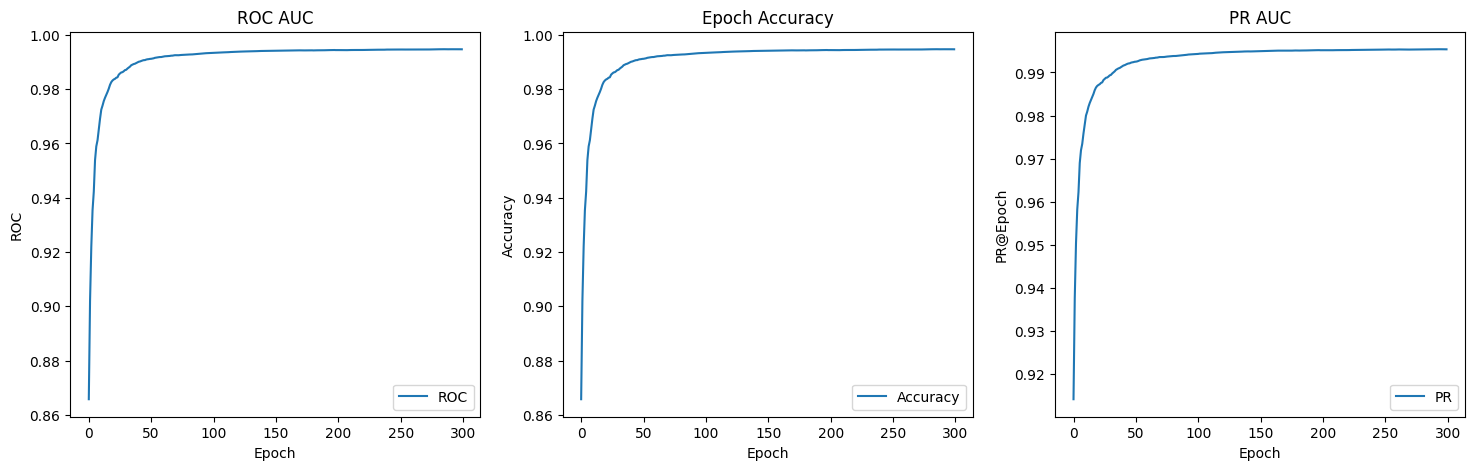

In [16]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['ROC_AUC'], label='ROC')
plt.title('ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['PR_AUC'], label='PR')
plt.title('PR AUC')
plt.xlabel('Epoch')
plt.ylabel('PR@Epoch')
plt.legend()    

In [17]:
# plt.figure(figsize=(14, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history['recall'], label='Recall')
# plt.title('Recall')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history['f1'], label='F1')
# plt.title('F1@Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('F1')
# plt.legend()

# # plt.subplot(1, 3, 3)
# # plt.plot(history['PR_AUC'], label='Accuracy')
# # plt.title('PR AUC')
# # plt.xlabel('Epoch')
# # plt.ylabel('PR@Epoch')
# # plt.legend()